In [7]:
%matplotlib inline

# Imports for Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *

# Various imports 
from copy import deepcopy
from matplotlib import pyplot as plt
import math
import numpy as np
import json
import itertools

# Load IBMQ account
#provider = IBMQ.load_account()

In [15]:
def qft(circ, q, n):
    """Perform a n-bit QFT on specified quantum register in specified circuit.
    
    :circ: The circuit in which the QFT is performed
    :q: The quantum register on which to perform the QFT
    :n: The number of bits"""
    
    # Put the gates of the QFT circuit
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cp(np.pi/float(2**(k-j)), q[k], q[j])
    
    # Swap qubits
    for j in range(n//2):
        circ.swap(q[j], q[n-j-1])
        
def inv_qft(circ, q, n):
    """Perform an n-bit inverse QFT on specified quantum register in specified circuit.
    
    :circ: The circuit in which the QFT is performed
    :q: The quantum register on which to perform the QFT
    :n: the number of bits"""
    
    # Swap qubits
    for j in range(n//2):
        circ.swap(q[j], q[n-j-1])
        
    # Put the gates of the inverse QFT circuit
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cp(-np.pi/float(2**(k-j)), q[k], q[j])
        circ.h(q[j])

In [16]:
def n_cry(circ, theta, control_qubits, target_qubit, inv = False):
    """Performs a n-controlled Y rotations of angle theta (n can be 1, 2 or 3).
    
    :circ: The circuit in which to perform the controlled rotations
    :theta: The angle of rotation
    :control_qubits: the qubits to be used as control (can be a list or quanutm register) but
                     the size of the register must be 1, 2 or 3
    :target_qubit: The target qubit
    :inv: To be set to True if the target qubit is above the control qubits in the circuit"""
    
    # Convert specified control qubits to a list
    control_list = control_qubits[:]
    size = len(control_list)
    
    
    if size > 3:
        print('Argument n is invalid!')
    else:
            
        if size == 1:
            circ.cry(theta, control_qubits[0], target_qubit)
        else:
            # To understand this part, please check section 6.3.1 of the report
            
            new_controls = control_qubits[:-1] if inv else control_qubits[1:]
            
            circ.mct(control_qubits, target_qubit, None, mode='advanced')
            n_cry(circ, -theta/2, new_controls, target_qubit, inv)
            circ.mct(control_qubits, target_qubit, None, mode='advanced')
            n_cry(circ, theta/2, new_controls, target_qubit, inv)

In [17]:
def postselect(statevector, qubit_number, value: bool):
    """Given a quantum state which is a tensor product of multiple qubits,
    compute the quantum state that would result if a specified qubit was found
    to be 1 or 0. 
    (Inspired by https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py,
    but slightly changed so that it better works)
    
    :statevector: The quantum state
    :qubit_number: The index of the qubit to be set to 1 or 0
    :value: The value to which the specified qubit is set
    """
    
    # Define a mask depending on the specified qubit
    mask = 1 << qubit_number
    
    # Depending on the desired value of the qubit, update the quantum state
    if value:
        array_mask = np.arange(len(statevector)) & mask
        array_mask = (array_mask != 0)
    else:
        array_mask = np.logical_not(np.arange(len(statevector)) & mask)
        
    def normalize(v):
        norm = np.linalg.norm(v)
        if norm == 0: 
            return v
        return v / norm
    
    # Return a normalized quantum state
    return normalize(statevector[array_mask])

In [18]:
def qpe(circ, clock_reg, target):
    """Create the QPE circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :clock_reg: The quantum register holding the eigenvalues
    :target: The qubit on which the successive powers of the operator is applied"""
    
    # Perform a Hadamard Transform
    circ.h(clock_reg)
    
    # Apply successive powers of our operator
    circuit.h(target)
    circuit.crz(3*np.pi/2, clock_reg[2], target)
    circuit.h(target)
    
    circuit.h(target)
    circuit.crz(-np.pi, clock_reg[1], target)
    circuit.h(target)
    
    circuit.crz(2*np.pi, clock_reg[0], target)
    
    # Perform an inverse QFT on the register holding the eigenvalues
    inv_qft(circuit, clock_reg, 3)
    
def inv_qpe(circ, clock_reg, target):
    """Create the inverse QPE circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :clock_reg: The quantum register holding the eigenvalues
    :target: The qubit on which the successive powers of the operator is applied"""
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock_reg, 3)
    
    # Apply successive powers of our operator (in reverse)
    circuit.crz(-2*np.pi, clock_reg[0], target)
    
    circuit.h(target)
    circuit.crz(np.pi, clock_reg[1], target)
    circuit.h(target)
    
    circuit.h(target)
    circuit.crz(-3*np.pi/2, clock_reg[2], target)
    circuit.h(target)
    
    # Perform a Hadamard Transform
    circ.h(clock_reg)

In [19]:
def hhl(circ, ancilla_reg, clock_reg, input_reg, measurement_reg):
    """Create the HHL circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :ancilla_reg: The quantum register holding the ancilla qubit
    :clock_reg: The quantum register holding the eigenvalues
    :input_reg: The quantum register holding the input (what we call |b>)
    :measurement_reg: The classical register holding the results of the mesurements"""
    
    # Perform the QPE designed specifically for our problem
    qpe(circ, clock_reg, input_reg)
    
    # Perform the controlled Y-rotations (for a better understanding of
    # where the numbers come from, please check section 8 of the report)
    circuit.cry(2.89385, clock_reg[1], ancilla_reg[0])
    circuit.cry(1.69612, clock_reg[0], ancilla_reg[0])
    n_cry(circuit, 0.24774, clock_reg[1:], ancilla_reg[0], inv=True)
    n_cry(circuit, -0.40912, clock_reg[::2], ancilla_reg[0], inv=True)
    n_cry(circuit, -3.54277, clock_reg[:2], ancilla_reg[0], inv=True)
    
    # Perform the inverse QPE specifically designed for our problem
    inv_qpe(circ, clock_reg, input_reg)

In [20]:
# Create the various registers needed
clock_reg = QuantumRegister(3, name='clock')
input_reg = QuantumRegister(1, name='input')
ancilla_reg = QuantumRegister(1, name='ancilla')
measurement_reg = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla_reg, clock_reg, input_reg, measurement_reg)

In [21]:
# Add the HHL circuit to the circuit
hhl(circuit, ancilla_reg, clock_reg, input_reg, measurement_reg)

# Save a version of the circuit with no measurement (useful for getting exact quantum state in simulator)
circuit_no_measure = deepcopy(circuit)

# Add measurements to the original circuit (for running on quantum computers)
circuit.measure(ancilla_reg, measurement_reg[0])
circuit.measure(input_reg, measurement_reg[1])

/var/folders/kh/vvf0y3ls11586918v2761md40000gn/T/ipykernel_15223/3480397572.py:27: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circ.mct(control_qubits, target_qubit, None, mode='advanced')
/var/folders/kh/vvf0y3ls11586918v2761md40000gn/T/ipykernel_15223/3480397572.py:29: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circ.mct(control_qubits, target_qubit, None, mode='advanced')


/Users/yuchao/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


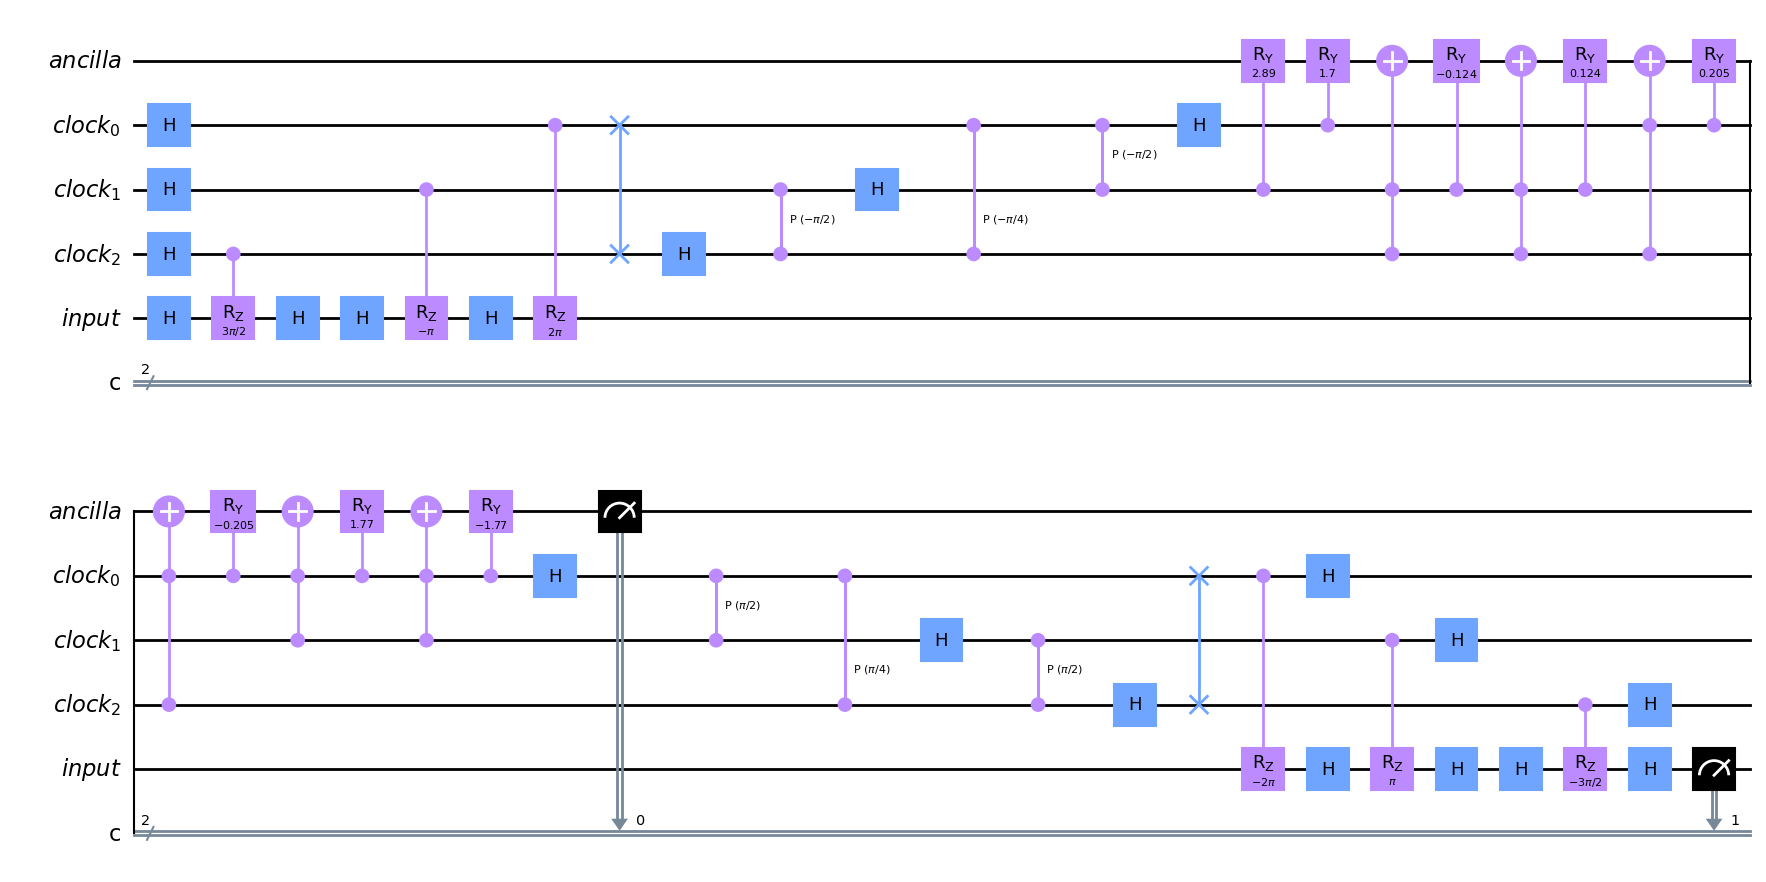

In [23]:
circuit.draw("mpl")

In [25]:
import qiskit
# Use  QASM simulator
simulator = qiskit.BasicAer.get_backend('statevector_simulator')

# The code below was inspired by https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py,
# but slightly changed

# Compute the result of the simulation
res_state = execute([circuit_no_measure], simulator).result()

# Get the output vector (all qubits included)
full_state = res_state.get_statevector()

# Get the output vector conditioned on ancilla value being 1
statevector = postselect(full_state, 0, value=1)

# This is hardcoded, in our case, need to select first and ninth
# element of the statevector to recover the solution
# These are the amplitudes for the value of x being 0 or 1,
# and values all 0 for the clock register, which in the final
# vector is on coordinates 0 and 8 
# (compute the tensor product of qubits to see why if unclear).
selector = np.zeros(16)
selector[0] = 1
selector[8] = 1
selector = (selector != 0)

# Get the output for qubit containing solution
x_experimental = statevector[selector]

# Multiply the quantum state of solution by constant to get the
# right answer (recall HHL gives a solution proportional to the true one)
solution = np.sqrt(17) * x_experimental

# The actual solution
x_exact = np.array([4, -1])

print("Exact solution: {}".format(x_exact))
print("Experimental solution: {}".format(solution))
print("Error in found solution: {}".format(np.linalg.norm(solution - x_exact)))

Exact solution: [ 4 -1]
Experimental solution: [ 3.99999935-1.59655314e-14j -1.00000261+5.38046054e-15j]
Error in found solution: 2.689219292638931e-06


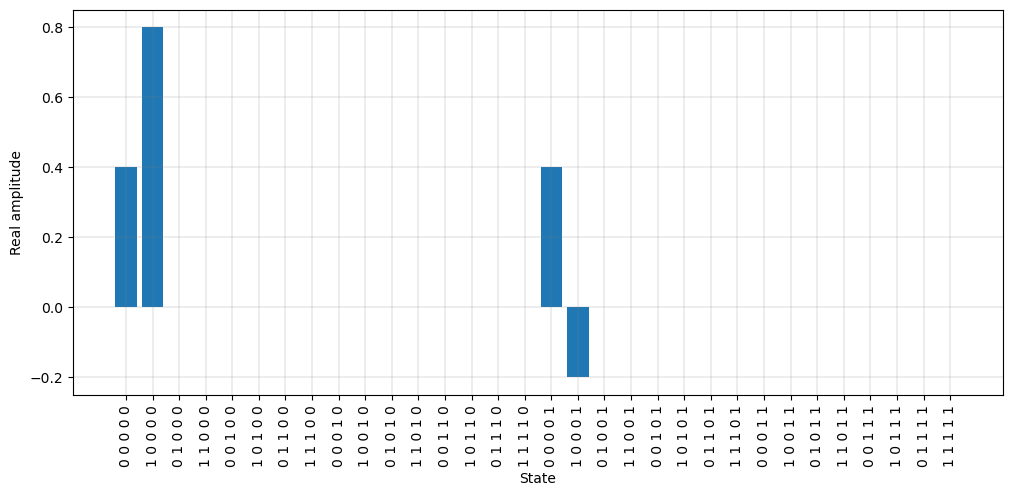

In [26]:
# The code below was inspired by https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py,
# but slightly changed to have a better visualization

n_states = len(full_state)
x_axis_values = np.arange(n_states)
x_axis_binary = [' '.join(bin(n)[3:])[::-1] for n in np.arange(n_states, 2 * n_states)]

plt.figure(figsize=(12, 5))
plt.grid(color='gray', linewidth =0.2)
plt.bar(x_axis_values, np.real(full_state))
plt.xticks(x_axis_values, x_axis_binary, rotation='vertical')
plt.ylabel('Real amplitude')
plt.xlabel('State')
plt.show()

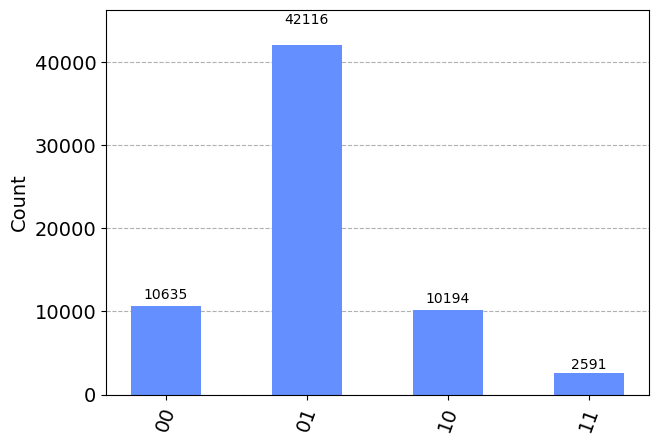

In [27]:
# Execute the circuit using the simulator
simulator = qiskit.BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# Display the results
plot_histogram(counts)

In [ ]:
def vqc_layer_ansatz(
    qubits,
    circ,
    parameters,
    layers = 2,
    entangler = "full" # "full" or "linear"
    ):

    for layer in range(layers):

        for d in range (0, len(qubits)):
            circ.rx(parameters[layer][d], qubits[d])
            circ.ry(parameters[layer][d], qubits[d])
            circ.rz(parameters[layer][d+len(qubits)], qubits[d])
            circ.h(qubits[d])

        circ.barrier()
        if entangler == "full":
            for i, j in itertools.combinations(qubits, 2):
                circ.cx(qubits[i], qubits[j])

        circ.barrier()

    for d in range (0, len(qubits)):
        circ.rx(parameters[layer][d], qubits[d])

    #circ.measure_all()
    #circ.measure()
    for n in range(len(qubits)-1):
        circ.measure(n, n)

In [ ]:
n_qubit = 4
layers  = 1
circ = QuantumCircuit(n_qubit,n_qubit-1)
vqc_layer_ansatz(qubits = list(range(n_qubit)),
           circ = circ,
           parameters = np.random.rand(layers+1, n_qubit*2),
           layers = layers,
           entangler = "full")
circ.draw(output='mpl', fold = 25)